### Aplicación de propensity score matching

In [26]:
##Borrar datos del entorno
rm(list=ls())

In [27]:
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,janitor,MatchIt,cobalt)


#### 1. Se cargan los datos tanto de la colonia Simi como de las colonias "similares" y 
se crea una dummy para identificar a qué grupo pertenece cada observación. Estos datos son a nivel manzana y se extrajeron del Censo de Población y Vivienda 2020.

In [28]:
#Cargar datos
datos_colonias<-openxlsx::read.xlsx("G:/Mi unidad/proyecto_simi/indicadores_mza_col.xlsx",sheet=2)%>%
#Crea dummy para identificar si la manzana pertenece a colonia simi o no
mutate(simi=case_when(colonia=="Lomas de San Carlos" ~ 1,
                        TRUE ~ 0))
str(datos_colonias)

'data.frame':	2904 obs. of  39 variables:
 $ cvegeo         : chr  "0900500010258020" "0900500010258035" "0900500010258009" "0900500012574009" ...
 $ cve_col        : chr  "09005_0019" "09005_0019" "09005_0019" "09005_0019" ...
 $ id_col         : num  17240 17240 17240 17240 17240 ...
 $ colonia        : chr  "Benito Juarez" "Benito Juarez" "Benito Juarez" "Benito Juarez" ...
 $ cve_ent        : chr  "09" "09" "09" "09" ...
 $ nom_ent        : chr  "Ciudad de México" "Ciudad de México" "Ciudad de México" "Ciudad de México" ...
 $ cve_mun        : chr  "005" "005" "005" "005" ...
 $ nom_mun        : chr  "Gustavo A. Madero" "Gustavo A. Madero" "Gustavo A. Madero" "Gustavo A. Madero" ...
 $ pobtot         : num  141 147 329 260 117 124 185 119 70 129 ...
 $ hogjef_f       : num  30 27 56 31 24 12 32 22 10 9 ...
 $ hogjef_m       : num  20 19 33 37 13 21 16 15 10 29 ...
 $ graproes       : num  8.91 9.19 8.75 8.44 8.34 ...
 $ pea            : num  77 68 155 117 50 58 87 63 39 56 ...
 $ p

In [29]:
#Contar unos y ceros de la dummy
datos_colonias%>%
    count(simi)

simi,n
<dbl>,<int>
0,2851
1,53


#### 2. Se ajusta un modelo probit para obtener el propensity score

In [30]:
var_modelo <- simi ~ hogjef_f + hogjef_m + graproes + pea + pocupada + 
              pe_inac + pocupada + pdesocup + pob0_14 + pob15_64 + pob65_mas

In [31]:
#Modelo probit
modelo_probit<-glm(var_modelo,
                     data=datos_colonias,family=binomial(link="probit"))
summary(modelo_probit)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = var_modelo, family = binomial(link = "probit"), 
    data = datos_colonias)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.169468   0.257440  -8.427  < 2e-16 ***
hogjef_f    -0.001087   0.017018  -0.064   0.9491    
hogjef_m     0.025554   0.014405   1.774   0.0761 .  
graproes     0.031545   0.027659   1.141   0.2541    
pea         -0.076610   0.091018  -0.842   0.4000    
pocupada     0.015783   0.086878   0.182   0.8558    
pe_inac     -0.042467   0.024924  -1.704   0.0884 .  
pdesocup    -0.113903   0.090695  -1.256   0.2092    
pob0_14      0.042366   0.010148   4.175 2.98e-05 ***
pob15_64     0.036525   0.025738   1.419   0.1559    
pob65_mas    0.029846   0.026386   1.131   0.2580    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 529.4  on 2903  degrees of freedom
Residual deviance: 488.1  on 2893  degrees of freedom
AIC: 5

#### 3. Se obtiene el propensity score y se realiza el matching

In [32]:
prs_df <- data.frame(pr_score = predict(modelo_probit, type = "response"),
                     simi = datos_colonias$simi)

In [33]:
matchit_out <- matchit(var_modelo,
                       data = datos_colonias, method = "nearest", distance = prs_df$pr_score)
matchit_out
summary(matchit_out)

A matchit object
 - method: 1:1 nearest neighbor matching without replacement
 - distance: User-defined
 - number of obs.: 2904 (original), 106 (matched)
 - target estimand: ATT
 - covariates: hogjef_f, hogjef_m, graproes, pea, pocupada, pe_inac, pdesocup, pob0_14, pob15_64, pob65_mas


Call:
matchit(formula = var_modelo, data = datos_colonias, method = "nearest", 
    distance = prs_df$pr_score)

Summary of Balance for All Data:
          Means Treated Means Control Std. Mean Diff. Var. Ratio eCDF Mean
distance         0.0324        0.0180          0.7269     1.2374    0.2526
hogjef_f         8.5094       11.5735         -0.4175     0.4303    0.0384
hogjef_m        18.9057       21.4749         -0.1908     0.4903    0.0250
graproes         9.2647        9.3526         -0.0922     0.1762    0.0774
pea             50.1698       64.0702         -0.3729     0.4419    0.0523
pocupada        49.3774       62.6086         -0.3607     0.4454    0.0505
pe_inac         31.4151       37.8050         -0.2764     0.5315    0.0385
pdesocup         0.2642        0.9670         -0.7293     0.1935    0.0247
pob0_14         27.6604       28.7106         -0.0478     0.7419    0.0220
pob15_64        70.1698       86.4963         -0.3130     0.5063    0.0505
pob65_mas        6.1132     

In [34]:
#Crear tabla con matcheados y el score de propensión
datos_matcheados<-match.data(matchit_out)
print(paste("Número de manzanas matcheadas:",nrow(datos_matcheados)))
#Número de manzanas matcheadas sin considerar Lomas de San Carlos
print(paste("Número de manzanas matcheadas sin considerar Lomas de San Carlos:",nrow(datos_matcheados[datos_matcheados$simi==0,])))
datos_matcheados

[1] "Número de manzanas matcheadas: 106"
[1] "Número de manzanas matcheadas sin considerar Lomas de San Carlos: 53"


,cvegeo,cve_col,id_col,colonia,cve_ent,nom_ent,cve_mun,nom_mun,pobtot,hogjef_f,⋯,pct_cister,pct_celular,pct_internet,pct_computadora,pct_tv_paga,pct_videos,simi,distance,weights,subclass
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
10,0900500012574038,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,129,9,⋯,0.000000,84.61538,43.58974,25.64103,15.384615,7.692308,0,0.048198757,1,10
17,0900500010258015,09005_0019,17240,Benito Juarez,09,Ciudad de México,005,Gustavo A. Madero,105,13,⋯,0.000000,81.48148,74.07407,44.44444,18.518519,22.222222,0,0.025630934,1,2
140,0900700014838009,09007_0013,17473,Ampliacion Emiliano Zapata,09,Ciudad de México,007,Iztapalapa,117,11,⋯,90.000000,90.00000,76.66667,26.66667,23.333333,26.666667,0,0.043328905,1,27
174,0900700012189005,09007_0051,17512,El Rosario,09,Ciudad de México,007,Iztapalapa,77,7,⋯,57.692308,80.76923,69.23077,30.76923,26.923077,19.230769,0,0.010332922,1,47
220,0900700012051095,09007_0056,17517,El Triangulo,09,Ciudad de México,007,Iztapalapa,88,8,⋯,16.000000,96.00000,48.00000,16.00000,0.000000,0.000000,0,0.026139155,1,3
284,0900700014289028,09007_0167,17628,San Francisco Apolocalco,09,Ciudad de México,007,Iztapalapa,147,10,⋯,68.421053,71.05263,63.15789,36.84211,26.315789,18.421053,0,0.041723277,1,24
320,0900700014293012,09007_0167,17628,San Francisco Apolocalco,09,Ciudad de México,007,Iztapalapa,145,7,⋯,88.095238,73.80952,66.66667,28.57143,28.571429,0.000000,0,0.051061547,1,12
476,090080001057A028,09008_0007,17695,El Ocotal,09,Ciudad de México,008,La Magdalena Contreras,154,11,⋯,6.666667,86.66667,77.77778,35.55556,26.666667,11.111111,0,0.071366383,1,32
712,0901700010899014,09017_0043,18749,Merced Balbuena,09,Ciudad de México,017,Venustiano Carranza,60,6,⋯,85.000000,80.00000,80.00000,75.00000,45.000000,45.000000,0,0.031424306,1,37


To identify the units, use first mouse button; to stop, use second.


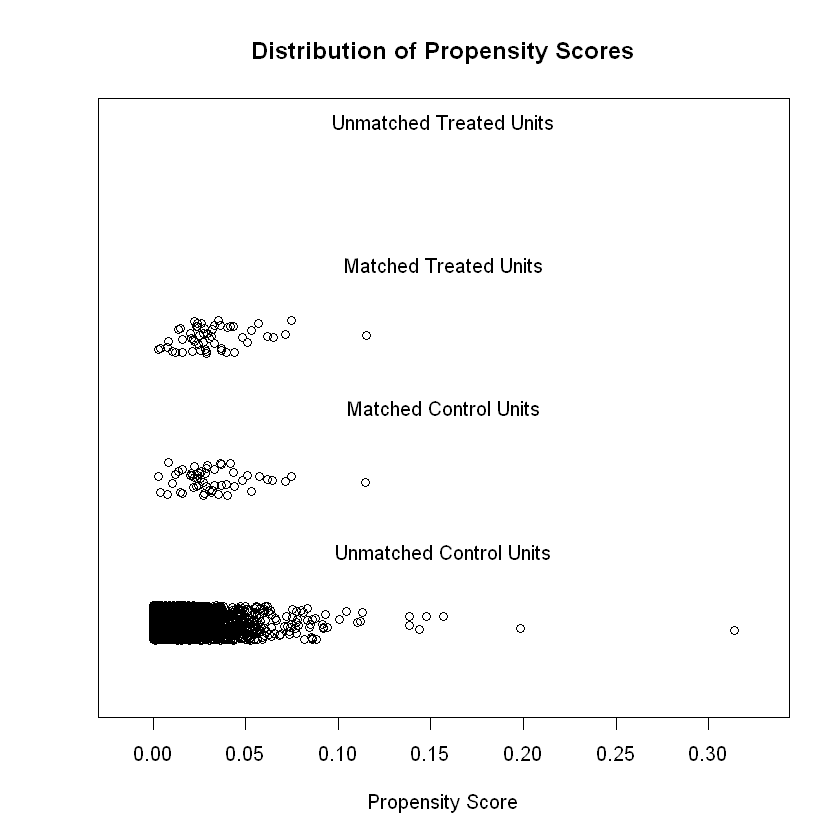

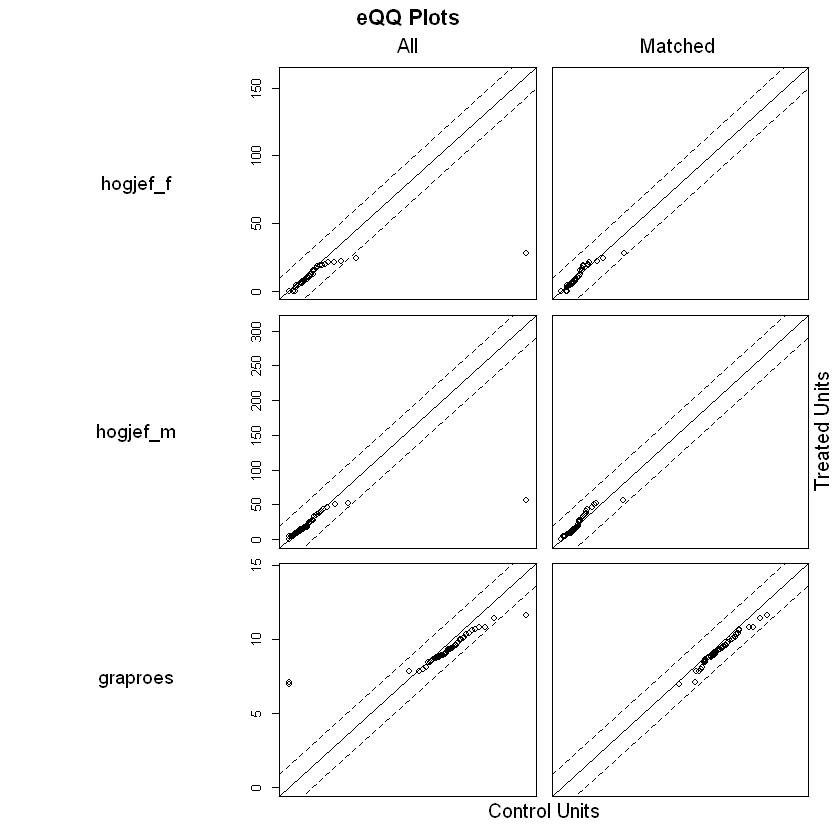

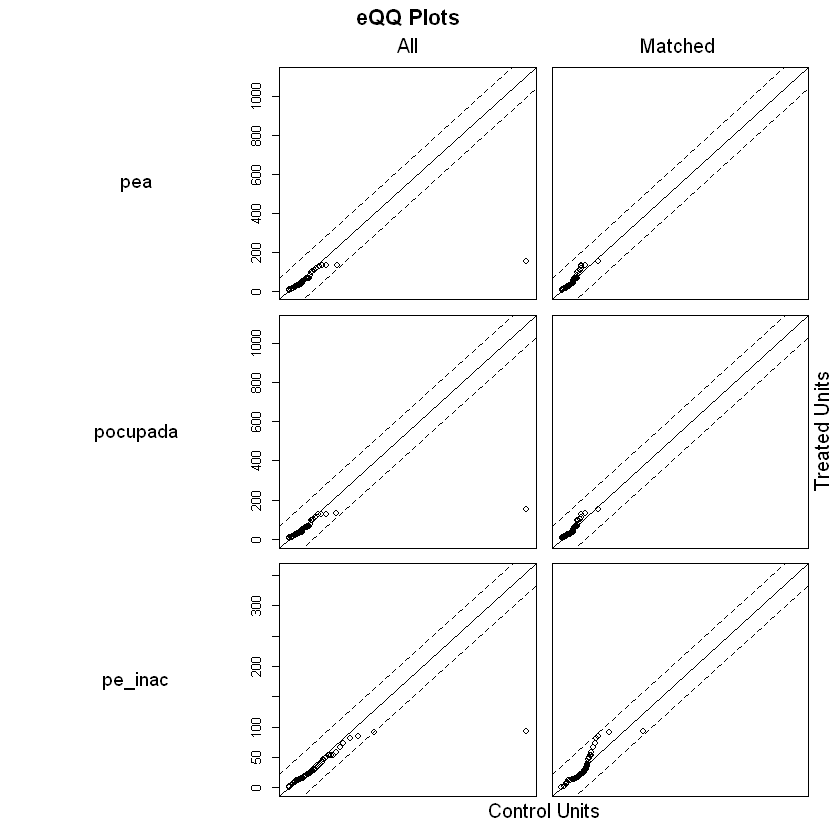

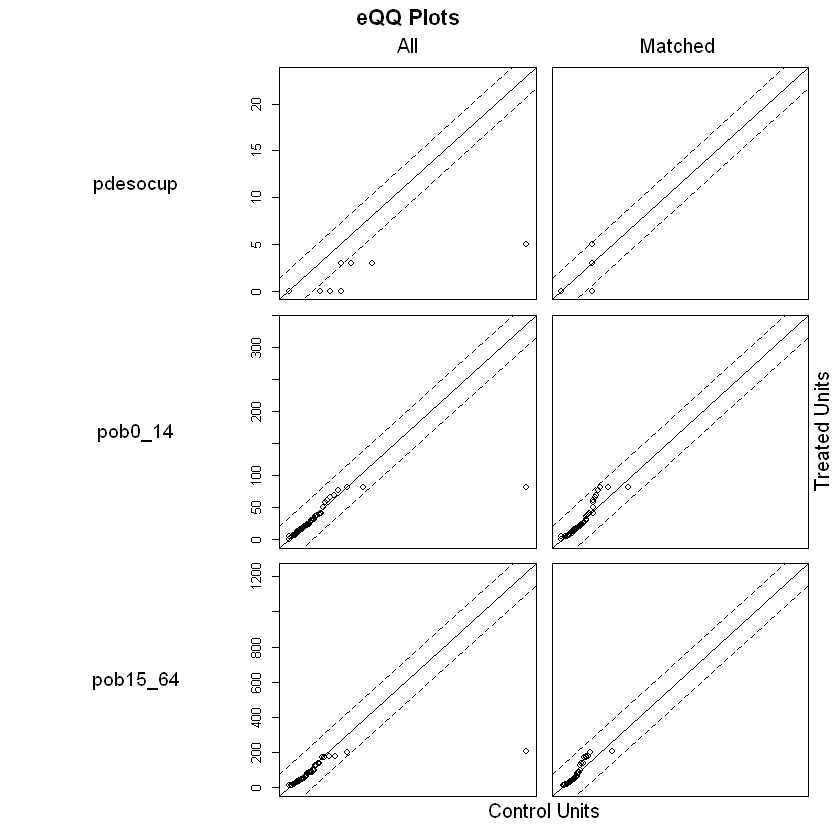

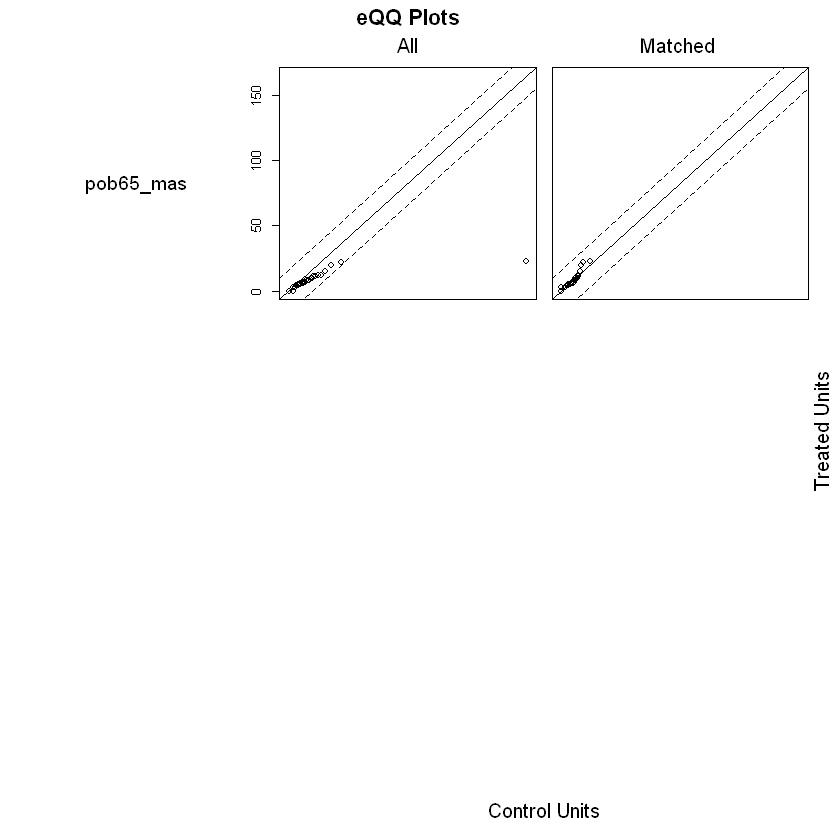

In [35]:
plot(matchit_out, type = "jitter")
plot(matchit_out, type = "qq")

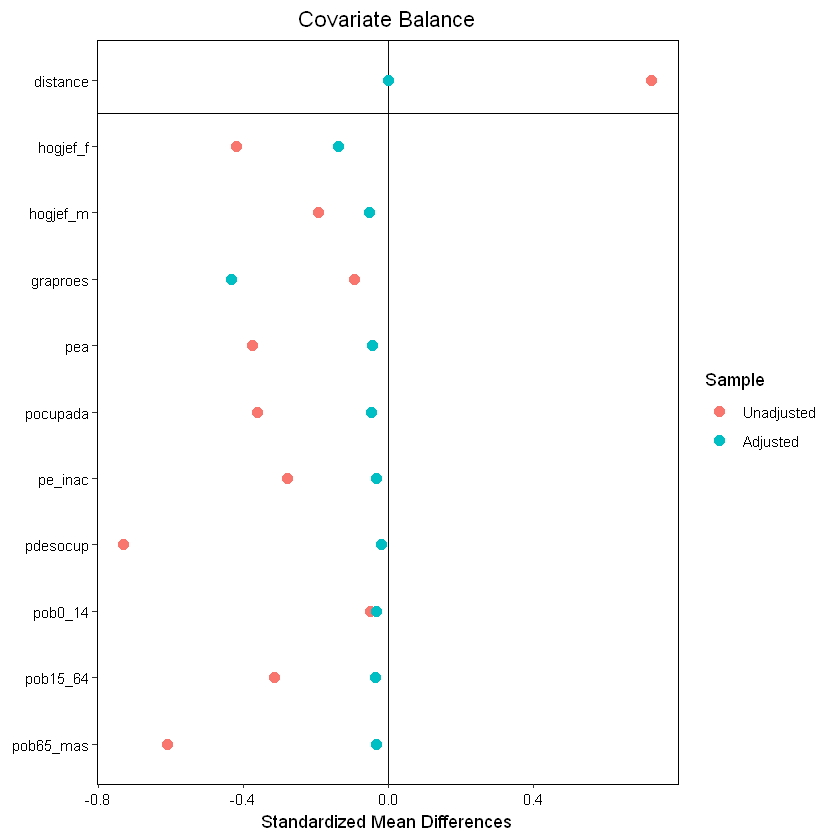

In [36]:
#Balance plot

love.plot(matchit_out)